In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [4]:
truth = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/subsets/cosmos_truth_clean.fits'))
print(len(truth))

# Remove objects with large sky residuals
for band in ['g', 'r', 'i', 'z']:
    truth[band+'_sky'] = (truth['apflux_blobresid_'+band][:, -1]-truth['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
mask = (truth['g_sky']>-0.002) & (truth['g_sky']<0.002)
print(np.sum(mask)/len(mask))
mask &= (truth['r_sky']>-0.003) & (truth['r_sky']<0.003)
print(np.sum(mask)/len(mask))
mask &= (truth['z_sky']>-0.006) & (truth['z_sky']<0.006)
print(np.sum(mask)/len(mask))
truth = truth[mask]
print(len(truth))

# Only keep isolated sources
mask = (truth['fracflux_g']>-0.01) & (truth['fracflux_g']<0.01)
print(np.sum(mask)/len(mask))
mask &= (truth['fracflux_r']>-0.01) & (truth['fracflux_r']<0.01)
print(np.sum(mask)/len(mask))
mask &= (truth['fracflux_z']>-0.01) & (truth['fracflux_z']<0.01)
print(np.sum(mask)/len(mask))
truth = truth[mask]
print(len(truth))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    truth['gmag'] = 22.5 - 2.5*np.log10(truth['flux_g']) - 3.214 * truth['ebv']
    truth['rmag'] = 22.5 - 2.5*np.log10(truth['flux_r']) - 2.165 * truth['ebv']
    truth['zmag'] = 22.5 - 2.5*np.log10(truth['flux_z']) - 1.211 * truth['ebv']
    truth['w1mag'] = 22.5 - 2.5*np.log10(truth['flux_w1']) - 0.184 * truth['ebv']
    truth['w2mag'] = 22.5 - 2.5*np.log10(truth['flux_w2']) - 0.113 * truth['ebv']
    truth['gmagerr'] = 1/np.sqrt(truth['flux_ivar_g'])/(truth['flux_g'])
    truth['rmagerr'] = 1/np.sqrt(truth['flux_ivar_r'])/(truth['flux_r'])
    truth['zmagerr'] = 1/np.sqrt(truth['flux_ivar_z'])/(truth['flux_z'])
    truth['w1magerr'] = 1/np.sqrt(truth['flux_ivar_w1'])/(truth['flux_w1'])
    truth['w2magerr'] = 1/np.sqrt(truth['flux_ivar_w2'])/(truth['flux_w2'])
    truth['gfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_g']) - 3.214 * truth['ebv']
    truth['rfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_r']) - 2.165 * truth['ebv']
    truth['zfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_z']) - 1.211 * truth['ebv']

truth_all = truth.copy()

1149893
0.9835628184535431
0.9732009847872802
0.9615285943996529
1105655
0.12092017853670449
0.09708724692603027
0.07313583351045308
80863


In [5]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

tmp = Table()
tmp['sub'], tmp['count'] = np.unique(subs['sub'], return_counts=True)
tmp

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
2752104


-------

In [6]:
mask = subs['sub']=='dr9_ccds'
sub = subs[mask].copy()
print(len(sub))

242278


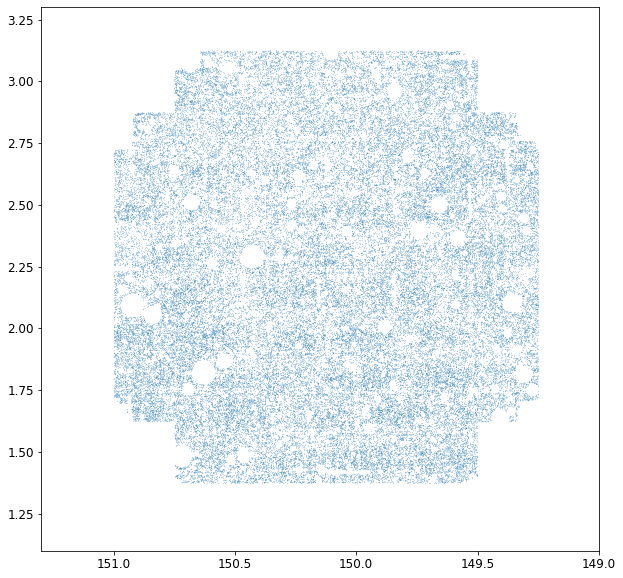

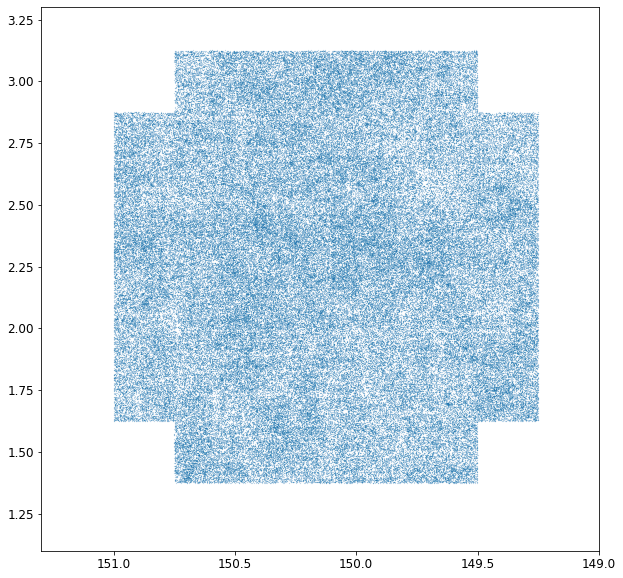

In [7]:
plt.figure(figsize=(10, 10))
plt.plot(truth['ra'], truth['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(sub['ra'], sub['dec'], '.', ms=0.2)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

Doubly matched objects = 2
Final matched objects = 41202


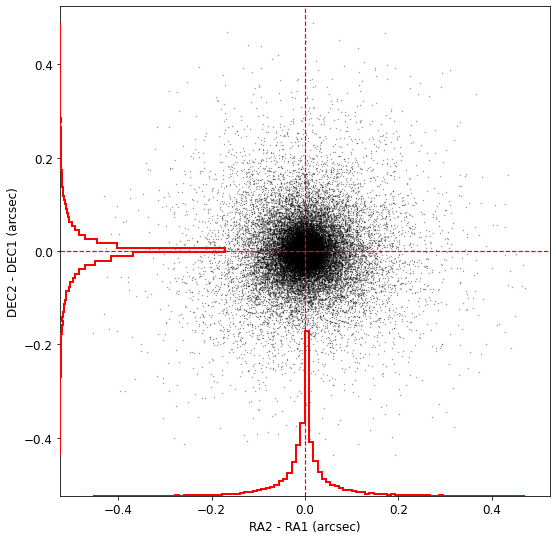

In [8]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], sub['ra'], sub['dec'], search_radius=0.5, plot_q=True)

truth = truth[idx1]
sub = sub[idx2]

---------

In [9]:
mask0 = truth['gmag']>20.
mask0 &= truth['gfibermag']<24.1
mask0 &= truth['type']!='PSF'
# mask0 &= (truth['type']=='REX') | (truth['type']=='EXP')

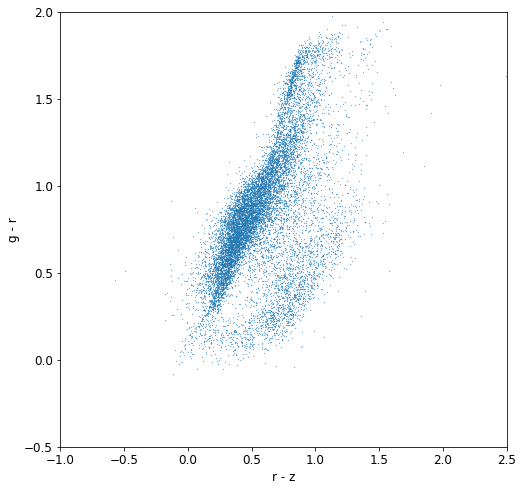

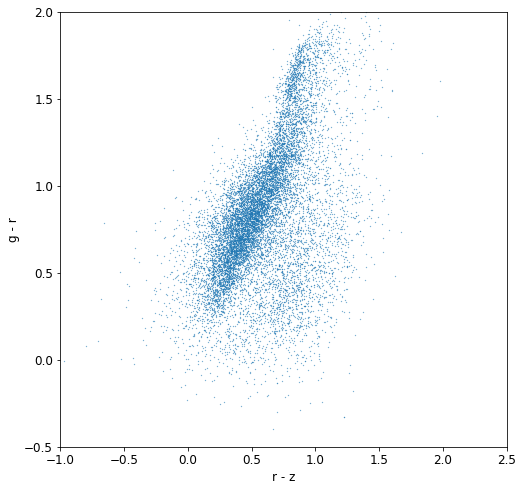

In [10]:
plt.figure(figsize=(8, 8))
plt.plot((truth['rmag']-truth['zmag'])[mask0], (truth['gmag']-truth['rmag'])[mask0], '.', ms=0.5)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((sub['rmag']-sub['zmag'])[mask0], (sub['gmag']-sub['rmag'])[mask0], '.', ms=0.5)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

## Magnitudes

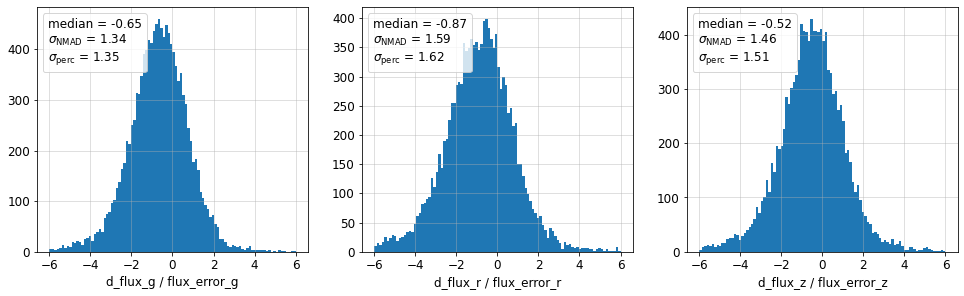

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
for index, band in enumerate(['g', 'r', 'z']):
    ax = axes[index]
    v = (sub['flux_'+band]-truth['flux_'+band]) / np.sqrt(1/sub['flux_ivar_'+band]+1/truth['flux_ivar_'+band])
    v = v[mask0]
    legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                 '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                 '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
    ax.hist(v, 100, range=(-6, 6), label=legend_text)
    ax.set_xlabel('d_flux_{} / flux_error_{}'.format(band, band, band))
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)
    ax.grid(alpha=0.5)
plt.show()

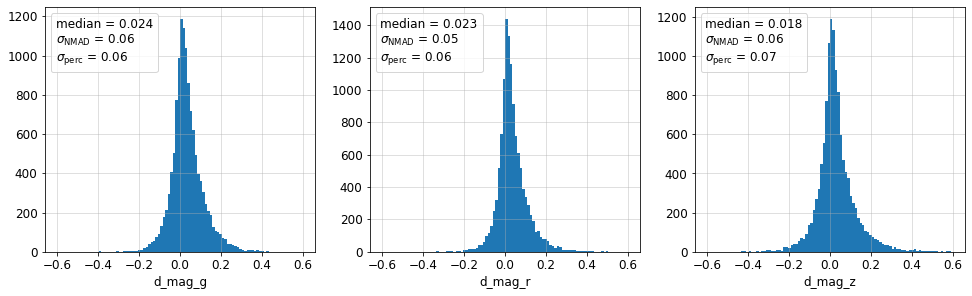

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
for index, band in enumerate(['g', 'r', 'z']):
    ax = axes[index]
    v = (sub[band+'mag']-truth[band+'mag'])  # magnitude
    v = v[mask0]
    legend_text = 'median = {:.3f}\n'.format(np.nanmedian(v))+\
                 '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                 '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
    ax.hist(v, 100, range=(-0.6, 0.6), label=legend_text)
    ax.set_xlabel('d_mag_{}'.format(band))
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)
    ax.grid(alpha=0.5)
plt.show()

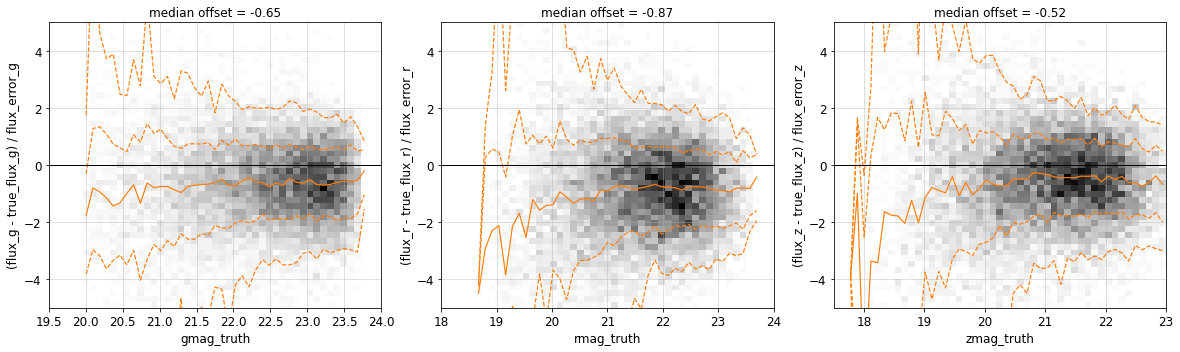

In [13]:
bands = ['g', 'r', 'z']
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-5, 5], [-5, 5], [-5, 5]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = bands[index]+'mag'
    v = (sub['flux_'+band]-truth['flux_'+band]) / np.sqrt(1/sub['flux_ivar_'+band]+1/truth['flux_ivar_'+band])
    x = truth[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('median offset = {:.2f}'.format(median_offset))
    ax.set_xlabel(mag_col+'_truth')
    ax.set_ylabel('(flux_{} - true_flux_{}) / flux_error_{}'.format(band, band, band))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

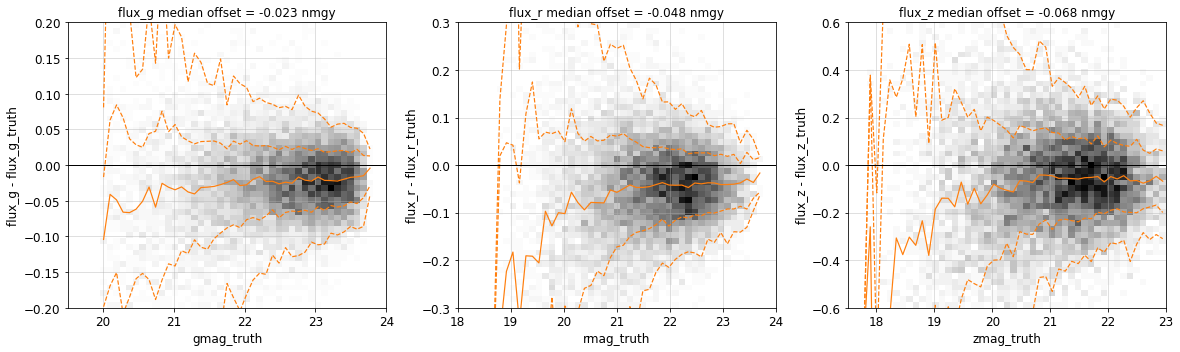

In [14]:
bands = ['g', 'r', 'z']
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-0.2, 0.2], [-0.3, 0.3], [-0.6, 0.6]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = bands[index]+'mag'
    v = (sub['flux_'+band]-truth['flux_'+band])
    x = truth[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('flux_{} median offset = {:.3f} nmgy'.format(band, median_offset))
    ax.set_xlabel(mag_col+'_truth')
    ax.set_ylabel('flux_{} - flux_{}_truth'.format(band, band))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

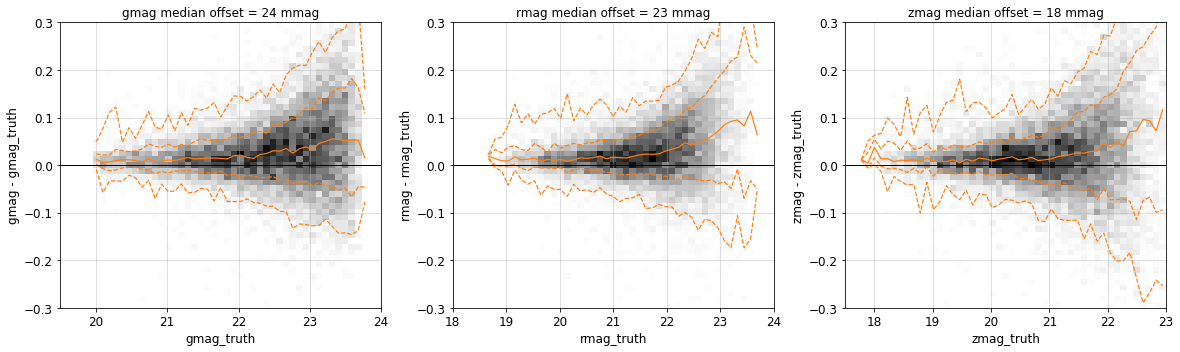

In [15]:
bands = ['g', 'r', 'z']
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-0.3, 0.3], [-0.3, 0.3], [-0.3, 0.3]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = band+'mag'
    v = sub[mag_col] - truth[mag_col]
    x = truth[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('{} median offset = {:.0f} mmag'.format(mag_col, median_offset*1000))
    ax.set_xlabel(mag_col+'_truth')
    ax.set_ylabel(mag_col+' - '+mag_col+'_truth')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

## Colors

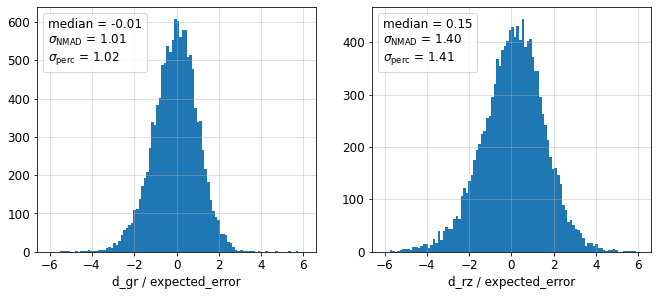

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(11., 4.5))
for index, color in enumerate([['g', 'r'], ['r', 'z']]):
    ax = axes[index]
    band1, band2 = color
    v = ((sub[band1+'mag']-sub[band2+'mag'])-(truth[band1+'mag']-truth[band2+'mag'])) / \
    np.sqrt(sub[band1+'magerr']**2+sub[band1+'magerr']**2+truth[band1+'magerr']**2+truth[band1+'magerr']**2)
    # v = ((sub[band1+'mag']-sub[band2+'mag'])-(truth[band1+'mag']-truth[band2+'mag']))
    v = v[mask0]
    legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                 '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                 '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
    ax.hist(v, 100, range=(-6, 6), label=legend_text)
    ax.set_xlabel('d_{}{} / expected_error'.format(band1, band2, band1, band2))
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)
    ax.grid(alpha=0.5)
plt.show()

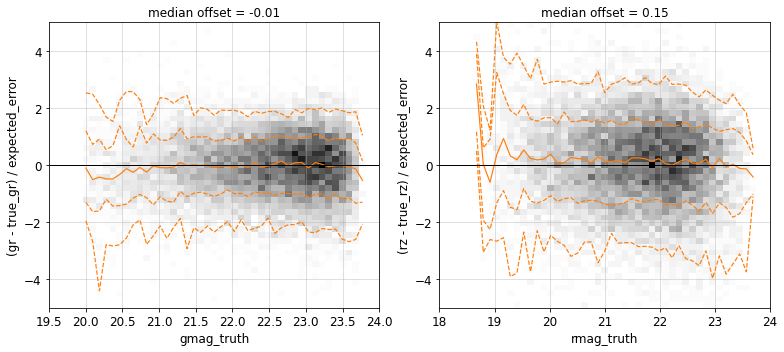

In [17]:
colors = [['g', 'r'], ['r', 'z']]
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-5, 5], [-5, 5], [-5, 5]]
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for index, color in enumerate(colors):
    band1, band2 = color
    ax = axes[index]
    mag_col = band1+'mag'
    v = ((sub[band1+'mag']-sub[band2+'mag'])-(truth[band1+'mag']-truth[band2+'mag'])) / \
    np.sqrt(sub[band1+'magerr']**2+sub[band1+'magerr']**2+truth[band1+'magerr']**2+truth[band1+'magerr']**2)
    x = truth[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('median offset = {:.2f}'.format(median_offset))
    ax.set_xlabel(mag_col+'_truth')
    ax.set_ylabel('({}{} - true_{}{}) / expected_error'.format(band1, band2, band1, band2))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

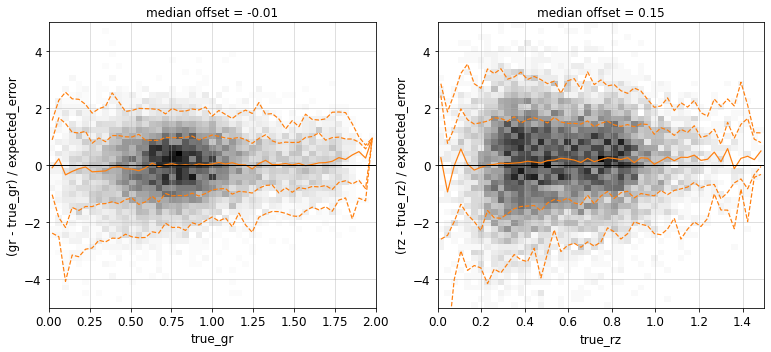

In [18]:
colors = [['g', 'r'], ['r', 'z']]
xlims = [[0, 2], [0, 1.5]]
ylims = [[-5, 5], [-5, 5]]
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for index, color in enumerate(colors):
    band1, band2 = color
    ax = axes[index]
    v = ((sub[band1+'mag']-sub[band2+'mag'])-(truth[band1+'mag']-truth[band2+'mag'])) / \
    np.sqrt(sub[band1+'magerr']**2+sub[band1+'magerr']**2+truth[band1+'magerr']**2+truth[band1+'magerr']**2)
    x = (truth[band1+'mag']-truth[band2+'mag'])
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('median offset = {:.2f}'.format(median_offset))
    ax.set_xlabel('true_{}{}'.format(band1, band2))
    ax.set_ylabel('({}{} - true_{}{}) / expected_error'.format(band1, band2, band1, band2))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
# lrg = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_lrg_1.1.1_basic.fits', columns=['RA', 'DEC', 'DESI_TARGET']))
# print(len(lrg))

# elg = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_basic.fits', columns=['RA', 'DEC', 'DESI_TARGET']))
# print(len(elg))

# idx1, idx2, d2d, d_ra, d_dec = match_coord(lrg['RA'], lrg['DEC'], truth['ra'], truth['dec'], search_radius=0.5, plot_q=True)
# mask_lrg = np.in1d(np.arange(len(truth)), idx2)

# idx1, idx2, d2d, d_ra, d_dec = match_coord(elg['RA'], elg['DEC'], truth['ra'], truth['dec'], search_radius=0.5, plot_q=True)
# mask_elg = np.in1d(np.arange(len(truth)), idx2)
# mask_elg_lop = np.in1d(np.arange(len(truth)), idx2[elg['DESI_TARGET'][idx1]&2**5>0])

## Fiber magnitude

/tmp/ipykernel_216564/1327185966.py:4: RuntimeWarning: divide by zero encountered in true_divide
  v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])
/tmp/ipykernel_216564/1327185966.py:4: RuntimeWarning: invalid value encountered in true_divide
  v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])


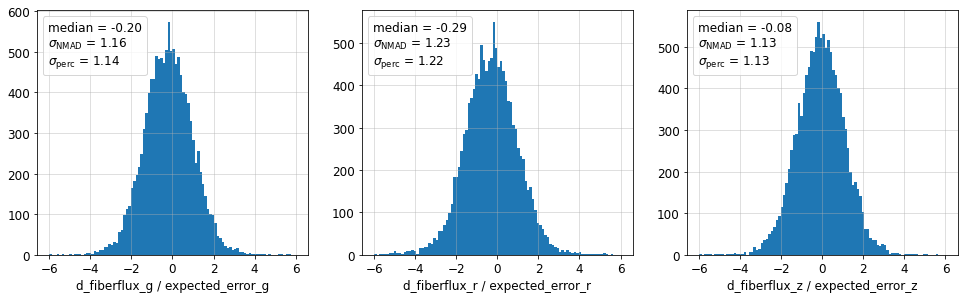

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
for index, band in enumerate(['g', 'r', 'z']):
    ax = axes[index]
    v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])
    # v = (sub[band+'fibermag']-truth[band+'fibermag']) / np.sqrt(sub[band+'magerr']**2 + truth[band+'magerr']**2)  # magnitude
    v = v[mask0]
    legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                 '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                 '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
    ax.hist(v, 100, range=(-6, 6), label=legend_text)
    ax.set_xlabel('d_fiberflux_{} / expected_error_{}'.format(band, band, band))
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)
    ax.grid(alpha=0.5)
plt.show()

/tmp/ipykernel_216564/3023221742.py:8: RuntimeWarning: divide by zero encountered in true_divide
  v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])
/tmp/ipykernel_216564/3023221742.py:8: RuntimeWarning: invalid value encountered in true_divide
  v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])


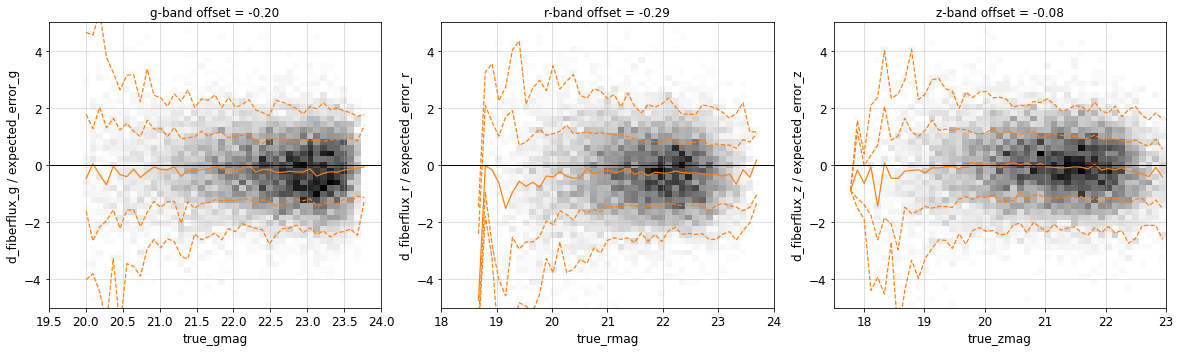

In [21]:
bands = ['g', 'r', 'z']
xlims = [[19.5, 24.], [18, 24], [17.5, 23.]]
ylims = [[-5, 5], [-5, 5], [-5, 5]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = bands[index]+'mag'
    v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])
    x = truth[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('{}-band offset = {:.2f}'.format(band, median_offset))
    ax.set_xlabel('true_'+mag_col)
    ax.set_ylabel('d_fiberflux_{} / expected_error_{}'.format(band, band, band))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

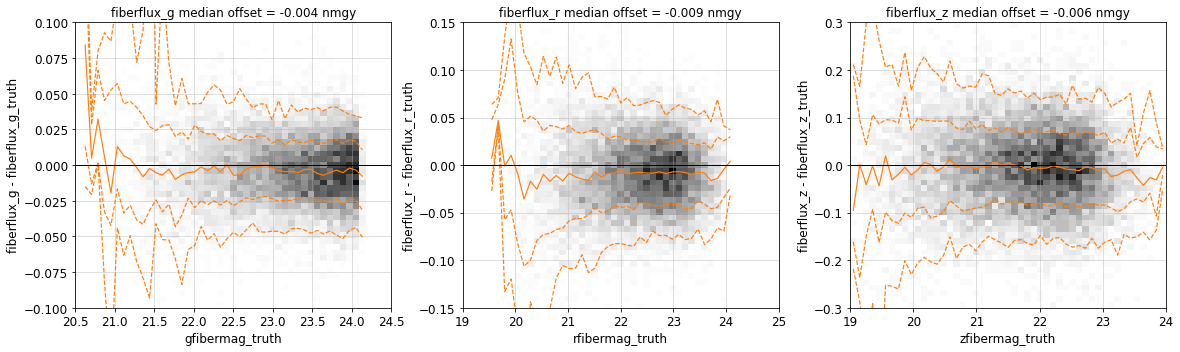

In [22]:
bands = ['g', 'r', 'z']
xlims = [[20.5, 24.5], [19, 25], [19, 24.]]
ylims = [[-0.1, 0.1], [-0.15, 0.15], [-0.3, 0.3]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    mag_col = bands[index]+'fibermag'
    v = (sub['fiberflux_'+band]-truth['fiberflux_'+band])
    x = truth[mag_col]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('fiberflux_{} median offset = {:.3f} nmgy'.format(band, median_offset))
    ax.set_xlabel(mag_col+'_truth')
    ax.set_ylabel('fiberflux_{} - fiberflux_{}_truth'.format(band, band))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_216564/531602989.py:7: RuntimeWarning: divide by zero encountered in true_divide
  v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])
/tmp/ipykernel_216564/531602989.py:7: RuntimeWarning: invalid value encountered in true_divide
  v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])


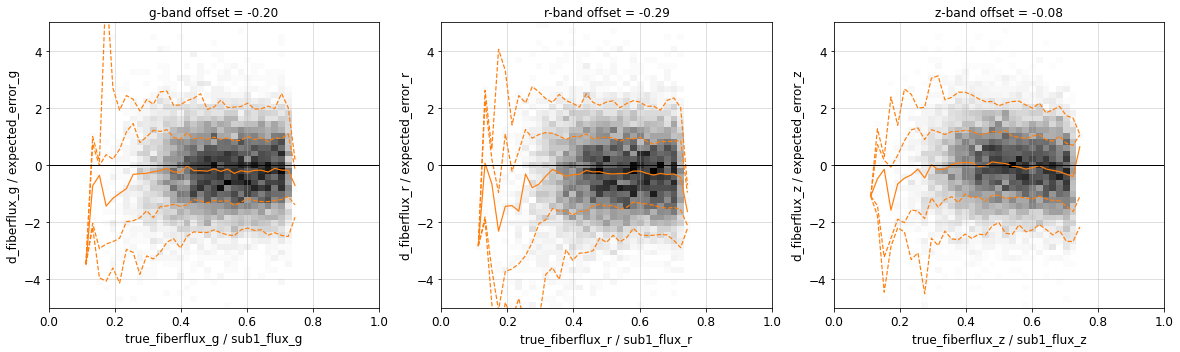

In [23]:
bands = ['g', 'r', 'z']
xlims = [[0, 1], [0, 1], [0, 1]]
ylims = [[-5, 5], [-5, 5], [-5, 5]]
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5))
for index, band in enumerate(bands):
    ax = axes[index]
    v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])
    x = truth['fiberflux_'+band]/truth['flux_'+band]
    mask = mask0 & (np.isfinite(v))
    median_offset = np.median(v[mask])
    xmin, xmax, ymin, ymax = xlims[index][0], xlims[index][1], ylims[index][0], ylims[index][1]
    xbins, ybins = np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50)
    bin_median, bin_edges, _ = stats.binned_statistic(x[mask], v[mask], statistic='median', bins=xbins)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 15.9), bins=xbins)
    bin_84, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 84.1), bins=xbins)
    bin_5, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 2.28), bins=xbins)
    bin_95, _, _ = stats.binned_statistic(x[mask], v[mask], statistic=lambda y: np.nanpercentile(y, 97.72), bins=xbins)
    ax.hist2d(x[mask], v[mask], bins=[xbins, ybins], cmap='gray_r')
    # plt.plot(x[mask], v[mask], '.', ms=0.1, alpha=0.2)  # simple scatter plot
    ax.plot(bin_centers, bin_median, 'C1', lw=1.2)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.2)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.2)
    ax.set_title('{}-band offset = {:.2f}'.format(band, median_offset))
    ax.set_xlabel('true_fiberflux_{} / sub1_flux_{}'.format(band, band))
    ax.set_ylabel('d_fiberflux_{} / expected_error_{}'.format(band, band, band))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', lw=1)
    ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

---------
## All subsets

sub-0
fluxes sub-0


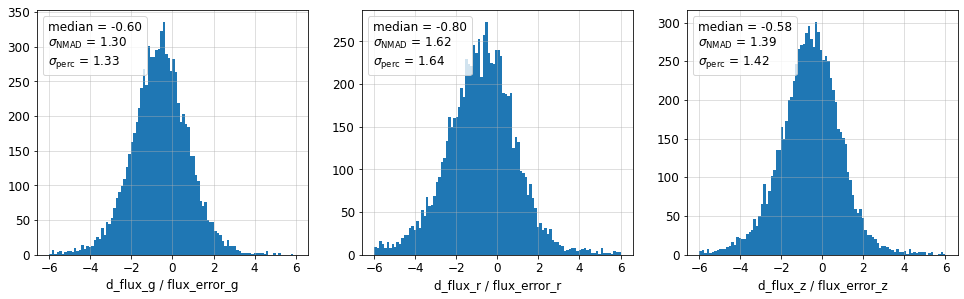

magnitudes sub-0


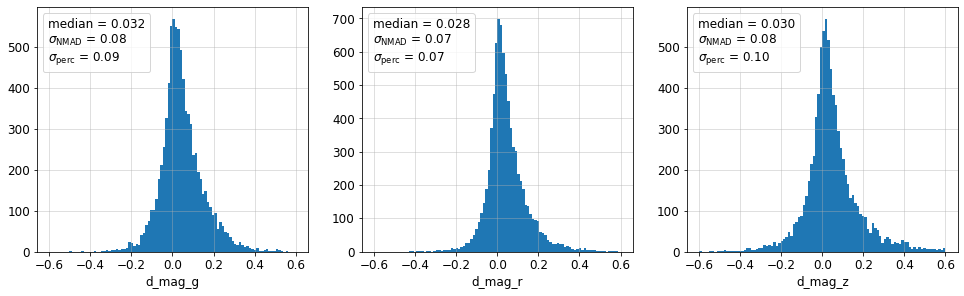

colors sub-0


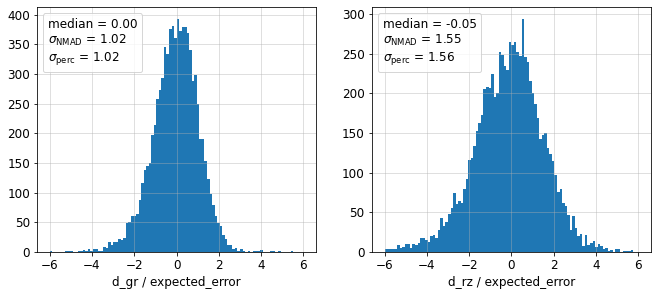

fibermag sub-0


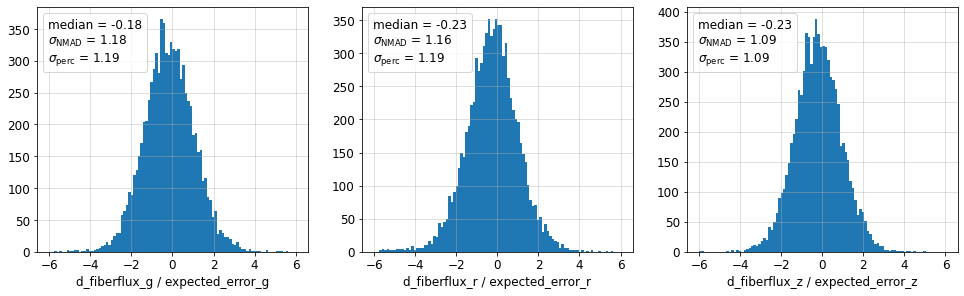



sub-1
fluxes sub-1


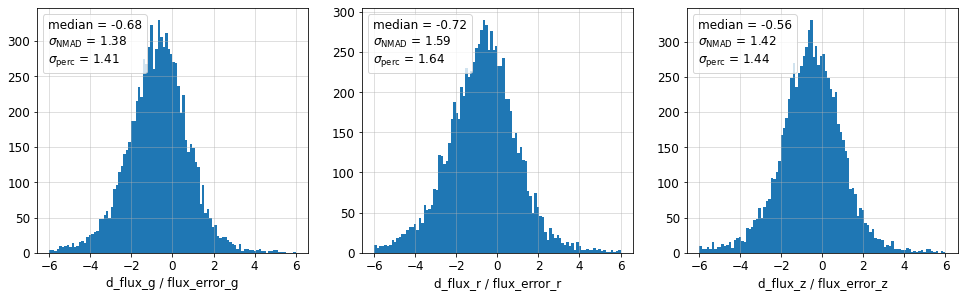

magnitudes sub-1


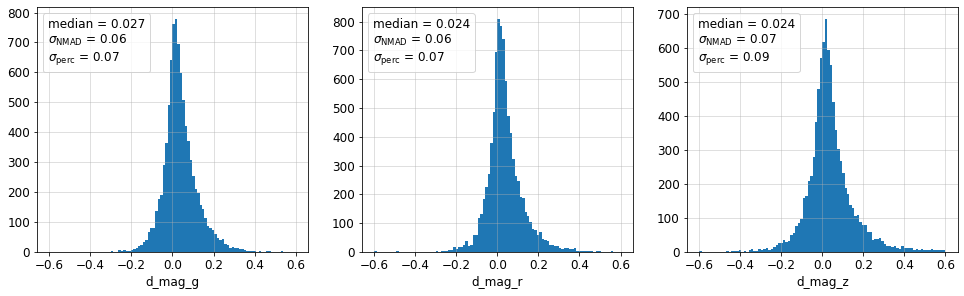

colors sub-1


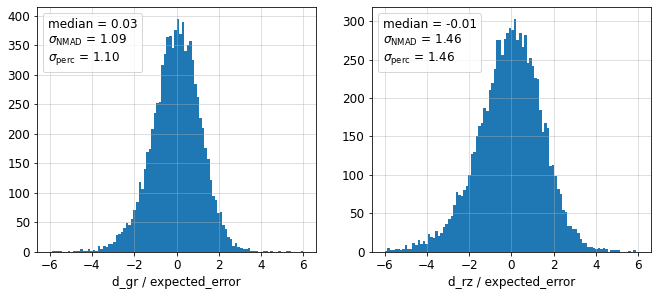

fibermag sub-1


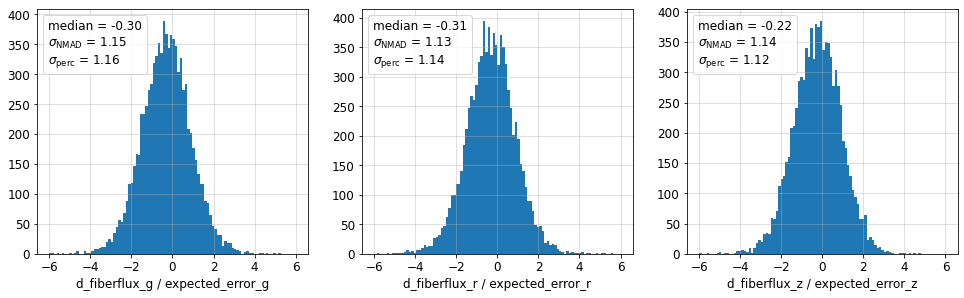



sub-2
fluxes sub-2


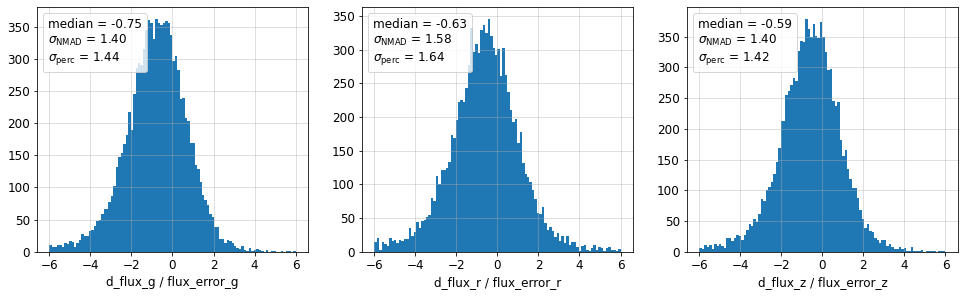

magnitudes sub-2


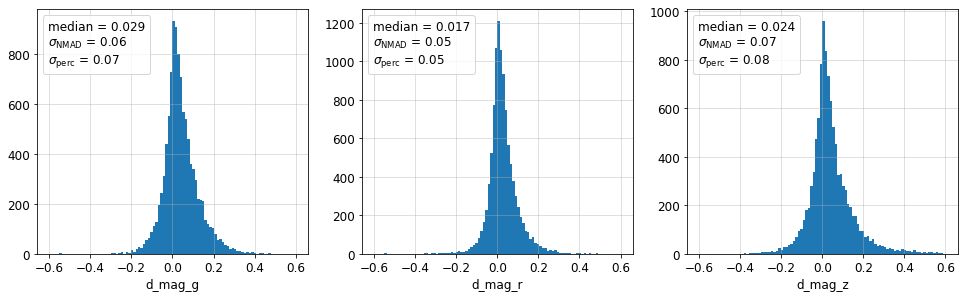

colors sub-2


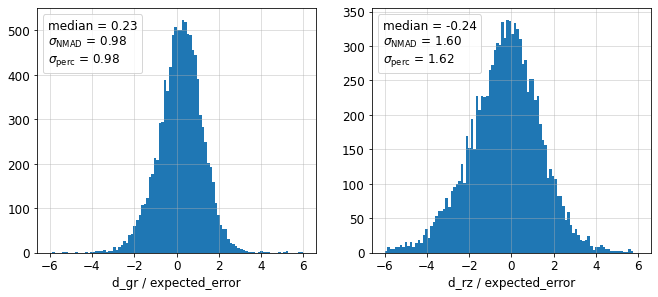

fibermag sub-2


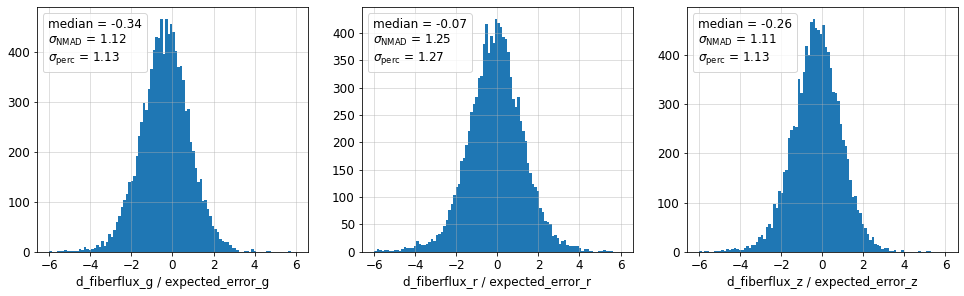



sub-3
fluxes sub-3


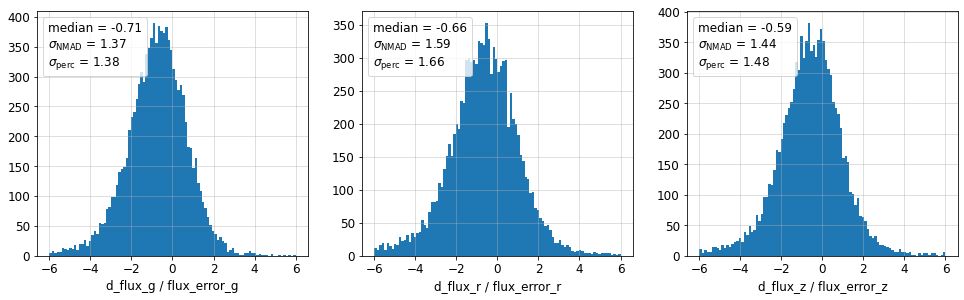

magnitudes sub-3


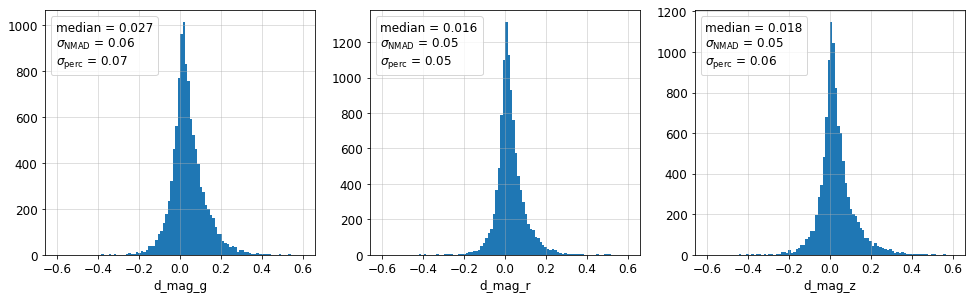

colors sub-3


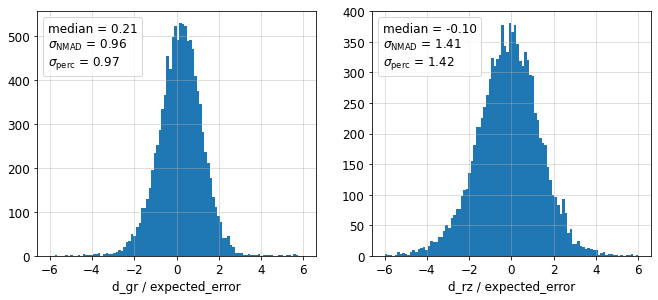

fibermag sub-3


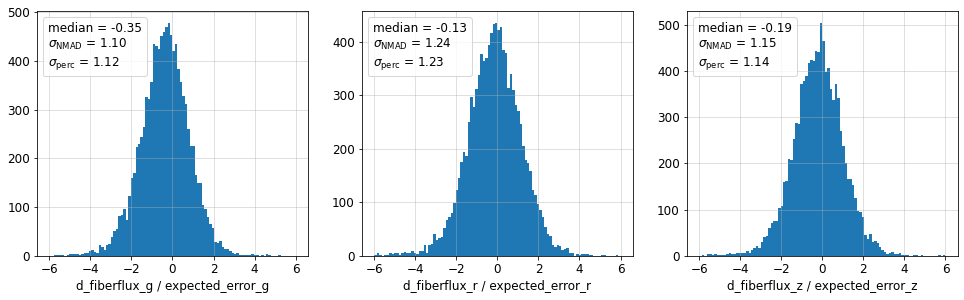



sub-4
fluxes sub-4


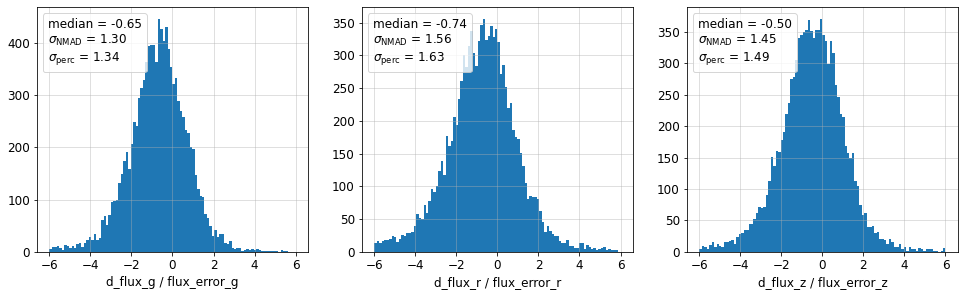

magnitudes sub-4


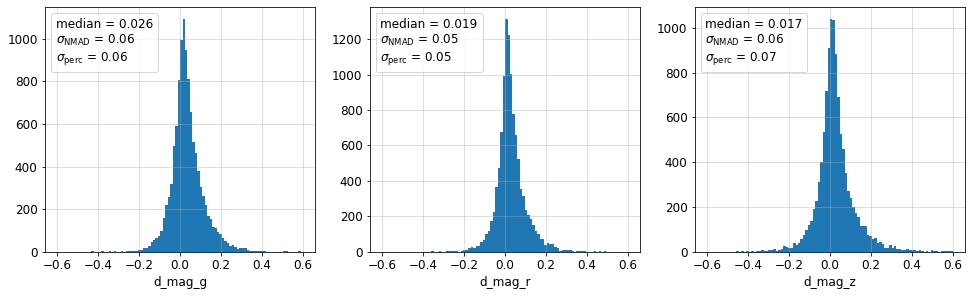

colors sub-4


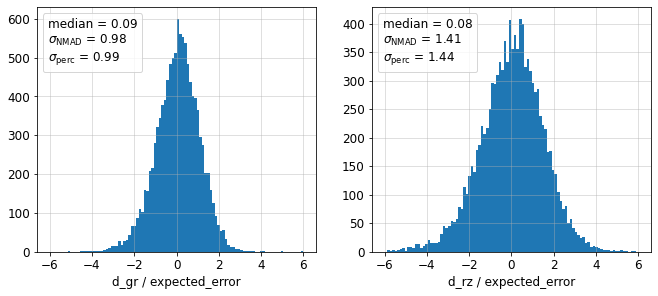

fibermag sub-4


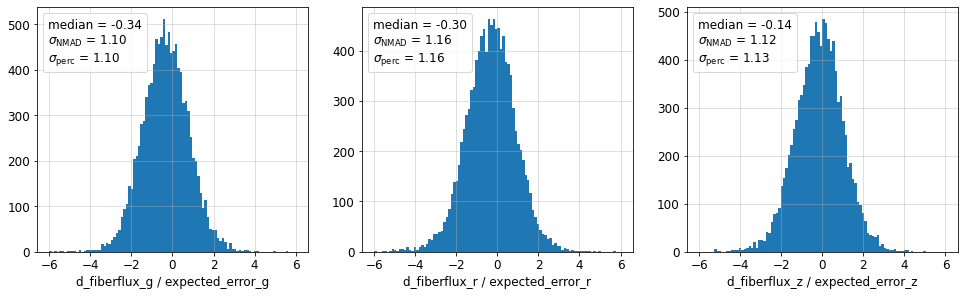



sub-5
fluxes sub-5


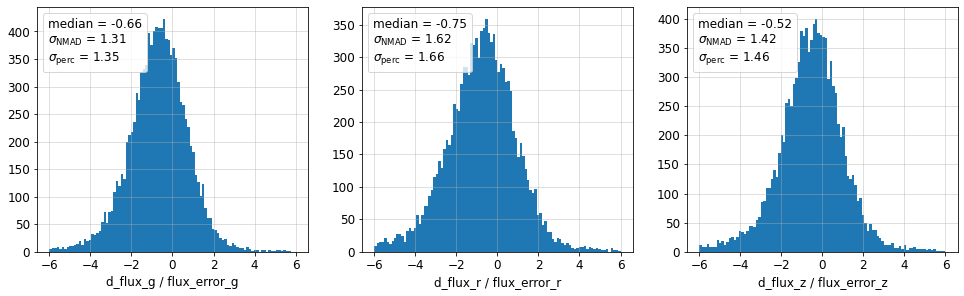

magnitudes sub-5


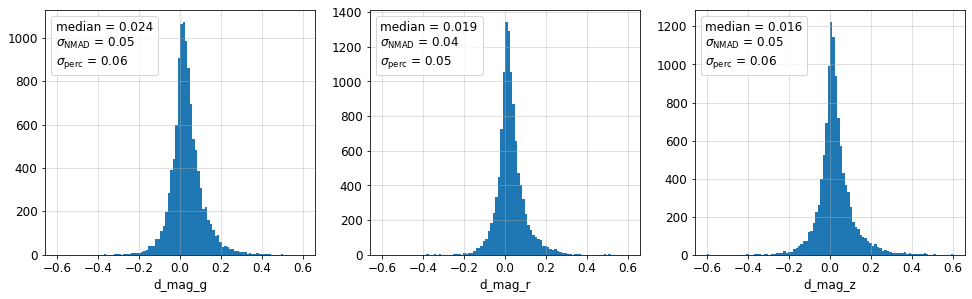

colors sub-5


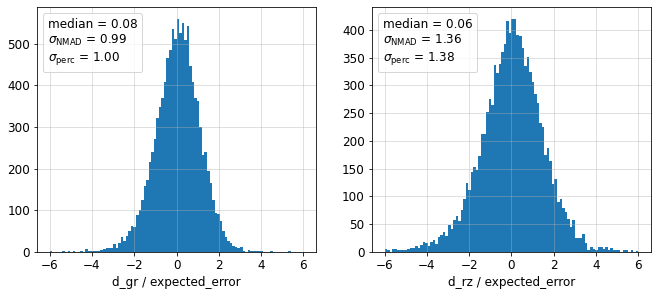

fibermag sub-5


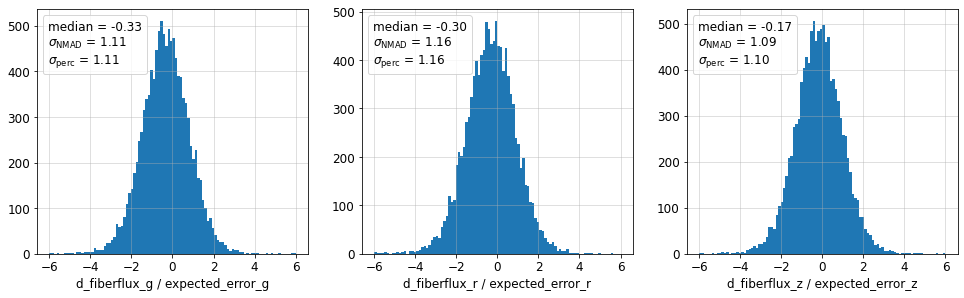



sub-6
fluxes sub-6


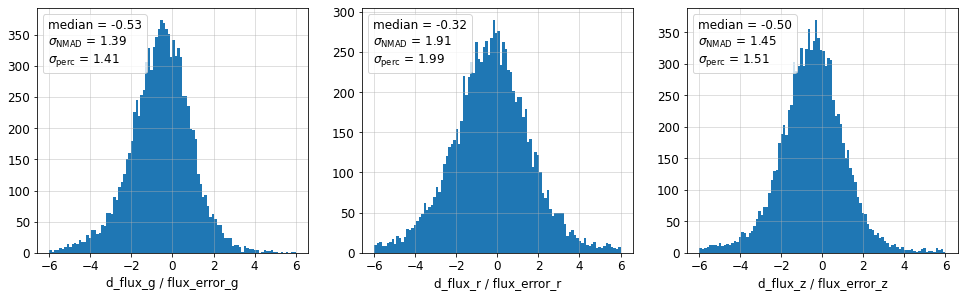

magnitudes sub-6


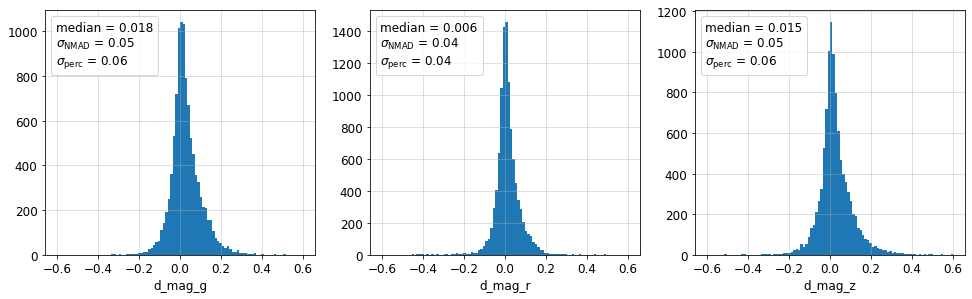

colors sub-6


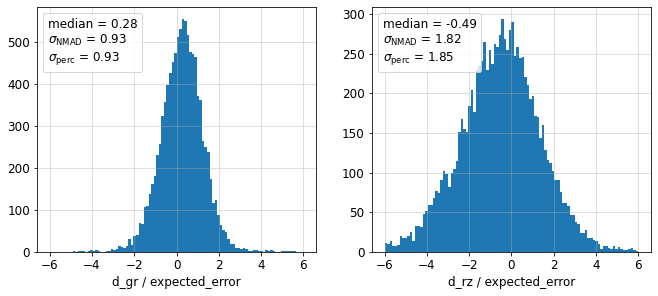

fibermag sub-6


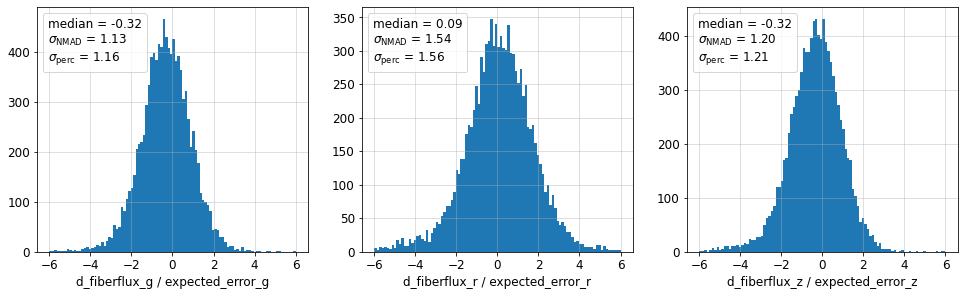



sub-7
fluxes sub-7


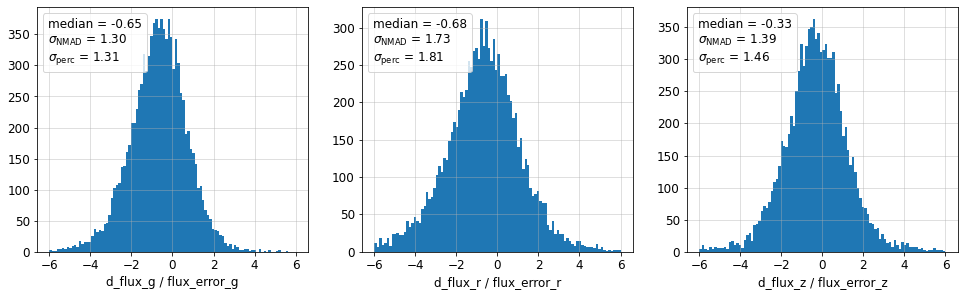

magnitudes sub-7


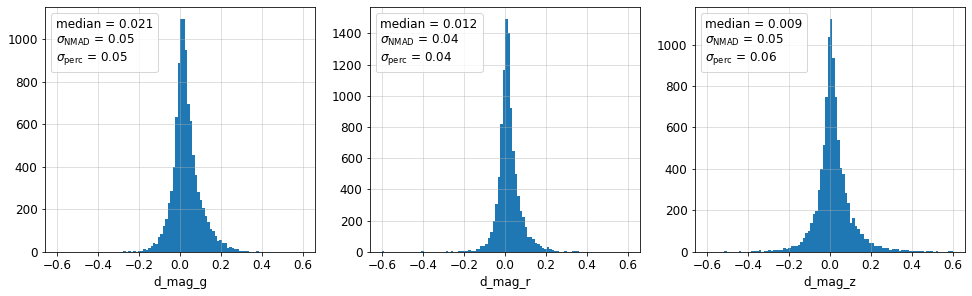

colors sub-7


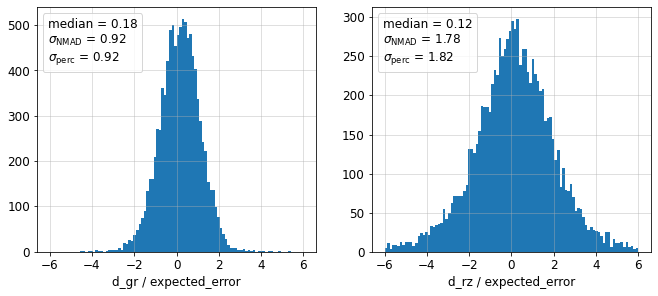

fibermag sub-7


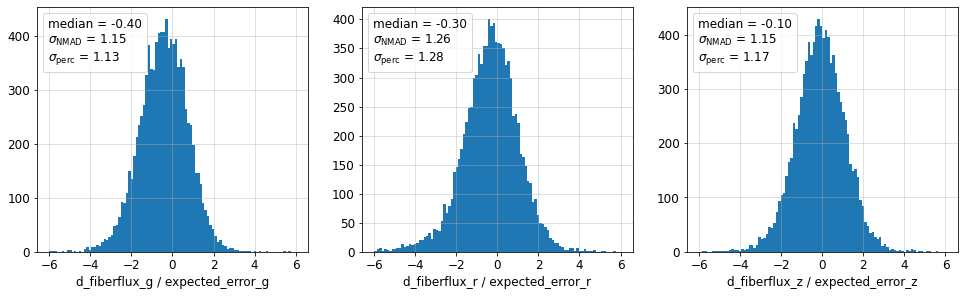



sub-8
fluxes sub-8


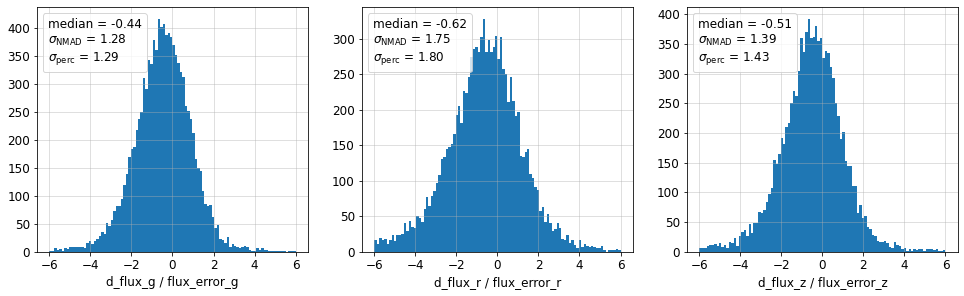

magnitudes sub-8


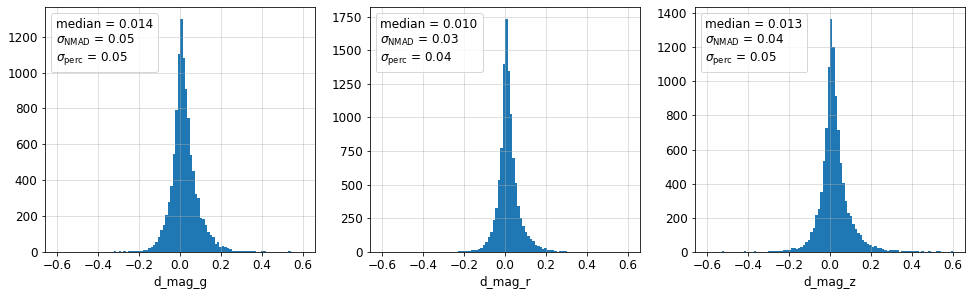

colors sub-8


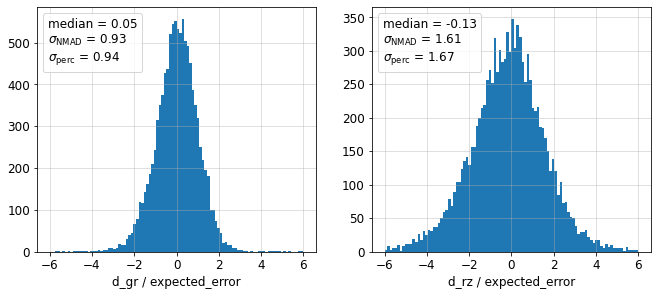

fibermag sub-8


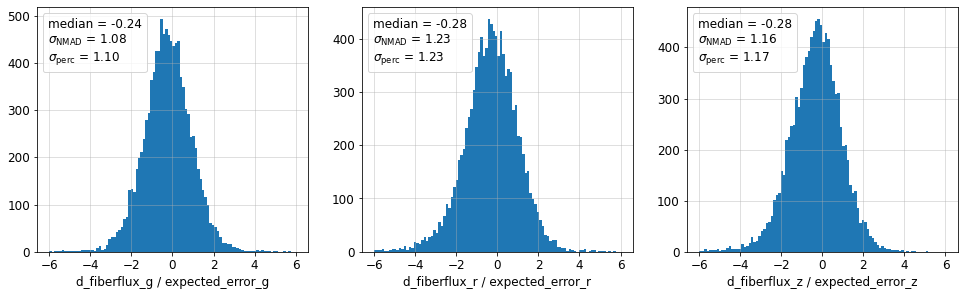



sub-9
fluxes sub-9


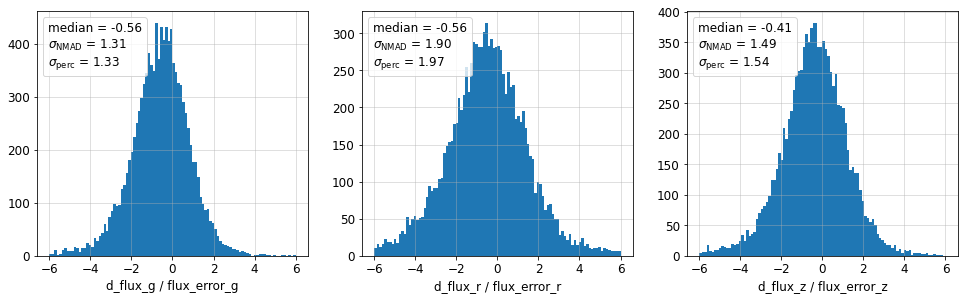

magnitudes sub-9


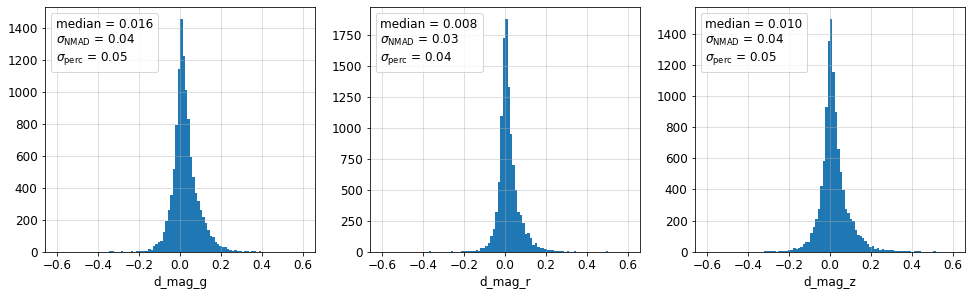

colors sub-9


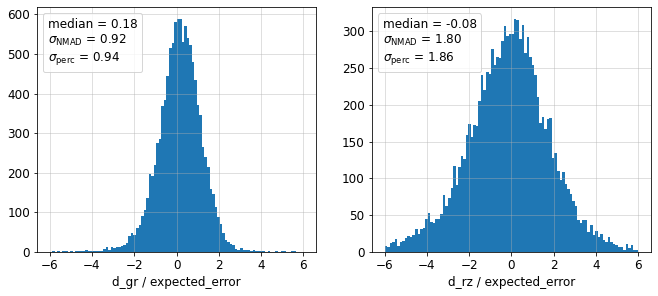

fibermag sub-9


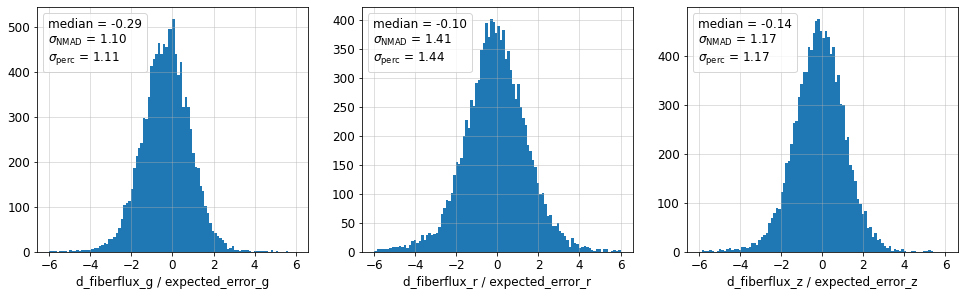

In [24]:
for subset_index in range(10):
    
    print('sub-{}'.format(subset_index))

    truth = truth_all.copy()

    mask = subs['sub']=='sub-{}'.format(subset_index)
    sub = subs[mask].copy()
    # print(len(sub))

    idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], sub['ra'], sub['dec'], search_radius=0.5, plot_q=False, verbose=False)

    truth = truth[idx1]
    sub = sub[idx2]


    mask0 = truth['gmag']>20.
    mask0 &= truth['gfibermag']<24.1
    mask0 &= truth['type']!='PSF'
    # mask0 &= (truth['type']=='REX') | (truth['type']=='EXP')


    print('fluxes sub-{}'.format(subset_index))
    fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
    for index, band in enumerate(['g', 'r', 'z']):
        ax = axes[index]
        v = (sub['flux_'+band]-truth['flux_'+band]) / np.sqrt(1/sub['flux_ivar_'+band]+1/truth['flux_ivar_'+band])
        v = v[mask0]
        legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                     '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                     '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
        ax.hist(v, 100, range=(-6, 6), label=legend_text)
        ax.set_xlabel('d_flux_{} / flux_error_{}'.format(band, band, band))
        ax.legend(loc='upper left', handlelength=0, handletextpad=0)
        ax.grid(alpha=0.5)
    plt.show()


    print('magnitudes sub-{}'.format(subset_index))
    fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
    for index, band in enumerate(['g', 'r', 'z']):
        ax = axes[index]
        v = (sub[band+'mag']-truth[band+'mag'])  # magnitude
        v = v[mask0]
        legend_text = 'median = {:.3f}\n'.format(np.nanmedian(v))+\
                     '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                     '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
        ax.hist(v, 100, range=(-0.6, 0.6), label=legend_text)
        ax.set_xlabel('d_mag_{}'.format(band))
        ax.legend(loc='upper left', handlelength=0, handletextpad=0)
        ax.grid(alpha=0.5)
    plt.show()


    print('colors sub-{}'.format(subset_index))
    fig, axes = plt.subplots(1, 2, figsize=(11., 4.5))
    for index, color in enumerate([['g', 'r'], ['r', 'z']]):
        ax = axes[index]
        band1, band2 = color
        v = ((sub[band1+'mag']-sub[band2+'mag'])-(truth[band1+'mag']-truth[band2+'mag'])) / \
        np.sqrt(sub[band1+'magerr']**2+sub[band1+'magerr']**2+truth[band1+'magerr']**2+truth[band1+'magerr']**2)
        # v = ((sub[band1+'mag']-sub[band2+'mag'])-(truth[band1+'mag']-truth[band2+'mag']))
        v = v[mask0]
        legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                     '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                     '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
        ax.hist(v, 100, range=(-6, 6), label=legend_text)
        ax.set_xlabel('d_{}{} / expected_error'.format(band1, band2, band1, band2))
        ax.legend(loc='upper left', handlelength=0, handletextpad=0)
        ax.grid(alpha=0.5)
    plt.show()


    print('fibermag sub-{}'.format(subset_index))
    fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
    for index, band in enumerate(['g', 'r', 'z']):
        ax = axes[index]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            v = (sub['fiberflux_'+band]-truth['fiberflux_'+band]) / np.sqrt((truth['fiberflux_'+band]/truth['flux_'+band])**2/sub['flux_ivar_'+band]+(truth['fiberflux_'+band]/truth['flux_'+band])**2/truth['flux_ivar_'+band])
        # v = (sub[band+'fibermag']-truth[band+'fibermag']) / np.sqrt(sub[band+'magerr']**2 + truth[band+'magerr']**2)  # magnitude
        v = v[mask0]
        legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                     '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                     '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
        ax.hist(v, 100, range=(-6, 6), label=legend_text)
        ax.set_xlabel('d_fiberflux_{} / expected_error_{}'.format(band, band, band))
        ax.legend(loc='upper left', handlelength=0, handletextpad=0)
        ax.grid(alpha=0.5)
    plt.show()
    
    print()
    print()